In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.decomposition import SparsePCA

%load_ext autoreload
%autoreload 2

In [47]:
from helpers import load_data, preprocess_data, load_data2, preprocess_data2

path_dataset = "data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


In [30]:
def split_data2(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_users, :][: , valid_items]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_users, nz_items = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[user,:].nonzero()
        selects = np.random.choice(col, size=int(len(col) * p_test))
        residual = list(set(col) - set(selects))

        # add to train set
        train[user, residual] = valid_ratings[user, residual]

        # add to test set
        test[user, selects] = valid_ratings[user, selects]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [31]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(987)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_users, :][: , valid_items]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_users, nz_items = valid_ratings.nonzero()
    
    # split the data
    for item in set(nz_items):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, item].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, item] = valid_ratings[residual, item]

        # add to test set
        test[selects, item] = valid_ratings[selects, item]

    print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in validated data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

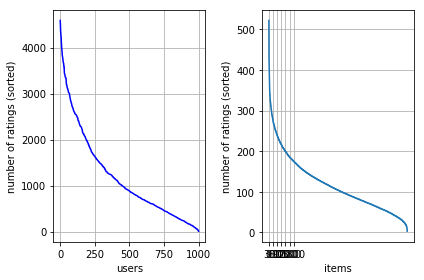

In [40]:
from plots import plot_raw_data
num_users_per_item, num_items_per_user = plot_raw_data(ratings)

In [38]:
len(num_items_per_user)

1000

In [41]:
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (10000, 1000)
Total number of nonzero elements in original data:1176952
Total number of nonzero elements in validated data:1176952
Total number of nonzero elements in train data:1065354
Total number of nonzero elements in test data:111598


In [13]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    
    for row, col in nz:
        item_info = item_features[:, col]
        user_info = user_features[:, row]

        mse += (data[row, col] - item_info.T.dot(user_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [66]:
def compute_error_final(data, user_features, item_features, nz, bias):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    
    user_bias = bias[1]
    item_bias = bias[2]
    mu = bias[0]
    
    for row, col in nz:
        item_info = item_features[:, col]
        user_info = user_features[:, row]

        mse += (data[row, col] - (mu + user_bias[row] + item_bias[col]) - item_info.T.dot(user_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [15]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_user, num_item = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=0)
    item_sum = train.sum(axis=0)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[0, ind] / item_nnz[ind]
    return user_features, item_features

In [62]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices, bias):
    """update user feature matrix."""
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    mu = bias[0] #train.mean()
    user_bias = bias[1] #train.mean(axis=1).flatten().T
    item_bias = bias[2] #train.mean(axis=0).flatten().T
        
    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        basis = train[user, items].copy().power(0)
        
        # update column row of user features
        V = M @ (train[user, items] - basis.multiply(mu + user_bias[user]) - item_bias[items].T).T
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:,user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices, bias):
    """update item feature matrix."""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))
    
    mu = bias[0] #train.mean()
    user_bias = bias[1] #train.mean(axis=1).flatten().T
    item_bias = bias[2] #train.mean(axis=0).flatten().T

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        basis = train[users, item].copy().power(0)
        M = user_features[:, users]
        V = M @ (train[users, item] - basis.multiply(mu + item_bias[item]) - user_bias[users])
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:,item] = np.copy(X.T)
    return updated_item_features

In [17]:
def collaborative_filtering(train, alpha):
    tmp = train.copy()
    C = tmp.power(0) + alpha*train
    P = train.tocsr().sign().tolil()
    return C, P

In [77]:
from helpers import build_index_groups


def ALS(train, test, ratings):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 110   # K in the lecture notes
    lambda_user = 0.09
    lambda_item = 0.09
    stop_criterion = 1e-5
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(1042)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    #C, P = collaborative_filtering(train, alpha)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=1), train.getnnz(axis=0)
    #nnz_items_c, nnz_users_c = C.getnnz(axis=1), C.getnnz(axis=0)
    
    # group the indices by row or column index
    nz_train, nz_user_itemindices, nz_item_userindices = build_index_groups(train)
    
    bias = ratings.mean(), ratings.mean(axis=1).flatten().T, ratings.mean(axis=0).flatten().T

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices, bias)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices, bias)

        error = compute_error_final(train, user_features, item_features, nz_train, bias)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error_final(test, user_features, item_features, nnz_test, bias)
    print("test RMSE after running ALS: {v}.".format(v=rmse))
    
    return user_features, item_features, error_list, bias

In [78]:
W, Z, error_l, bias = ALS(train, test, ratings)


start the ALS algorithm...
RMSE on training set: [[ 1.25007678]].
RMSE on training set: [[ 0.94800073]].
RMSE on training set: [[ 0.90192496]].
RMSE on training set: [[ 0.88001668]].
RMSE on training set: [[ 0.86696064]].
RMSE on training set: [[ 0.85837079]].
RMSE on training set: [[ 0.85239428]].
RMSE on training set: [[ 0.84807576]].
RMSE on training set: [[ 0.84486603]].
RMSE on training set: [[ 0.84242733]].
RMSE on training set: [[ 0.84054115]].
RMSE on training set: [[ 0.83906]].
RMSE on training set: [[ 0.83788106]].
RMSE on training set: [[ 0.83693091]].
RMSE on training set: [[ 0.83615629]].
RMSE on training set: [[ 0.83551805]].
RMSE on training set: [[ 0.83498703]].
RMSE on training set: [[ 0.83454128]].
RMSE on training set: [[ 0.83416405]].
RMSE on training set: [[ 0.83384244]].
RMSE on training set: [[ 0.8335664]].
RMSE on training set: [[ 0.83332802]].
RMSE on training set: [[ 0.83312101]].
RMSE on training set: [[ 0.83294034]].
RMSE on training set: [[ 0.83278191]].
R

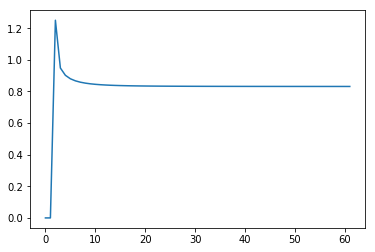

In [81]:
plt.plot(error_l)

0.98363615

In [79]:
pred = W.T@Z

In [72]:
W.shape

(100, 10000)

In [21]:
path_dataset2 = "sample_submission.csv"
sub_ex = load_data(path_dataset2)

number of items: 10000, number of users: 1000


In [80]:
import csv

def create_csv_submission(pred_nonzero, approx, train, name, bias, round_=False):
    mu = bias[0]#train.mean()
    user_bias = bias[1] #train.mean(axis=1).flatten().T
    item_bias = bias[2] #train.mean(axis=0).flatten().T
    
    nnz_row, nnz_col = train.nonzero()
    
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for row, col in pred_nonzero:
            ids = 'r' + str(row+1) + '_c' + str(col+1)
            
            """if row in nnz_row and col in nnz_col:
                bias = (mu + user_bias[row] + item_bias[col])
            elif row in nnz_row:
                bias =  mu + user_bias[row]
            elif col in nnz_row:
                bias = mu + item_bias[col]"""
            
            b = mu + user_bias[row] + item_bias[col]
            
            if round_:
                value = round(approx[row, col] + b)
            else:
                value = approx[row, col] + b
                
            value = value.item(0)
                
            writer.writerow({'Id':ids,'Prediction':value})
            
create_csv_submission(list(zip(*sub_ex.nonzero())), pred, train, 'potato2.csv', bias)

In [51]:
data = load_data2('potato.csv')

number of items: 10000, number of users: 1000


In [ ]:
def create_csv_submission(pred_nonzero, approx, train, name, round_=False):
    
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for row, col in pred_nonzero:
            ids = 'r' + str(row+1) + '_c' + str(col+1)
            
            if row in nnz_row and col in nnz_col:
                bias = 0.5*(user_bias[row] + item_bias[col])
            elif row in nnz_row:
                bias = user_bias[row]
            elif col in nnz_row:
                bias = item_bias[col]
            
            if round_:
                value = round(approx[row, col] + bias)
            else:
                value = approx[row, col] + bias
                
            writer.writerow({'Id':ids,'Prediction':value})
            
create_csv_submission(list(zip(*sub_ex.nonzero())), pred, train, 'potato.csv')